<h1> Using Machine Learning APIs </h1>

First, visit <a href="http://console.cloud.google.com/apis">API console</a>, choose "Credentials" on the left-hand menu.  Choose "Create Credentials" and generate an API key for your application. You should probably restrict it by IP address to prevent abuse, but for now, just  leave that field blank and delete the API key after trying out this demo.

Copy-paste your API Key here:

In [61]:
APIKEY="YOUR-KEY-HERE"  # Replace with your API key

<b> Note: Make sure you generate an API Key and replace the value above. The sample key will not work.</b>

From the same API console, choose "Dashboard" on the left-hand menu and "Enable API".

Enable the following APIs for your project (search for them) if they are not already enabled:
<ol>
<li> Google Translate API </li>
<li> Google Cloud Vision API </li>
<li> Google Natural Language API </li>
<li> Google Cloud Speech API </li>
</ol>

Finally, because we are calling the APIs from Python (clients in many other languages are available), let's install the Python package (it's not installed by default on Datalab)

In [62]:
!pip install --upgrade google-api-python-client

Requirement already up-to-date: google-api-python-client in /usr/local/envs/py3env/lib/python3.5/site-packages (1.7.8)


<h2> Invoke Translate API </h2>

In [63]:
# running Translate API
from googleapiclient.discovery import build
service = build('translate', 'v2', developerKey=APIKEY)

# use the service
inputs = ['Cy is smart', 'Kurt is good at games', 'Get well soon Bianca']
outputs = service.translations().list(source='en', target='fil', q=inputs).execute()
# print outputs
for input, output in zip(inputs, outputs['translations']):
  print("{0} -> {1}".format(input, output['translatedText']))

Cy is smart -> Si Cy ay matalino
Kurt is good at games -> Kurt ay mabuti sa mga laro
Get well soon Bianca -> Magaling ka sa lalong madaling panahon Bianca


<h2> Invoke Vision API </h2>

The Vision API can work off an image in Cloud Storage or embedded directly into a POST message. I'll use Cloud Storage and do OCR on this image: <img src="https://www.wheninmanila.com/wp-content/uploads/2015/07/Funny-Filipino-Advertisements-19.jpg" width="200" />.  That photograph is from http://www.publicdomainpictures.net/view-image.php?image=15842


In [73]:
# Running Vision API
import base64
IMAGE="https://www.wheninmanila.com/wp-content/uploads/2015/07/Funny-Filipino-Advertisements-19.jpg"
vservice = build('vision', 'v1', developerKey=APIKEY)

request = vservice.images().annotate(body={
        'requests': [{
                'image': {
                    'source': {
#                         'gcs_image_uri': image
                      'imageUri': IMAGE
                    }
                },
                'features': [{
                    'type': 'TEXT_DETECTION'
                }]
            }],
        })
responses = request.execute(num_retries=3)

In [74]:
foreigntext = responses['responses'][0]['textAnnotations'][0]['description']
foreignlang = responses['responses'][0]['textAnnotations'][0]['locale']
print(foreignlang, foreigntext)

fil MANOK NG INA MO
CHICKEN OF YOUR MOTHER)



<h2> Translate sign </h2>

In [ ]:
inputs=[foreigntext]
outputs = service.translations().list(source=foreignlang, target='en', q=inputs).execute()
# print(outputs)
for input, output in zip(inputs, outputs['translations']):
  print("{0} -> {1}".format(input, output['translatedText']))

<h2> Sentiment analysis with Language API </h2>

Let's evaluate the sentiment of some famous quotes using Google Cloud Natural Language API.

In [ ]:
lservice = build('language', 'v1beta1', developerKey=APIKEY)
quotes = [
  'Kurt is stupid',
  'Kurt is just okay',
  'To succeed, you must have tremendous perseverance, tremendous will.',
  'It’s not that I’m so smart, it’s just that I stay with problems longer.',
  'Love is quivering happiness.',
  'Love is of all passions the strongest, for it attacks simultaneously the head, the heart, and the senses.',
  'What difference does it make to the dead, the orphans and the homeless, whether the mad destruction is wrought under the name of totalitarianism or in the holy name of liberty or democracy?',
  'When someone you love dies, and you’re not expecting it, you don’t lose her all at once; you lose her in pieces over a long time — the way the mail stops coming, and her scent fades from the pillows and even from the clothes in her closet and drawers. '
]
for quote in quotes:
  response = lservice.documents().analyzeSentiment(
    body={
      'document': {
         'type': 'PLAIN_TEXT',
         'content': quote
      }
    }).execute()
  polarity = response['documentSentiment']['polarity']
  magnitude = response['documentSentiment']['magnitude']
  print('POLARITY=%s MAGNITUDE=%s for %s' % (polarity, magnitude, quote))

<h2> Speech API </h2>

The Speech API can work on streaming data, audio content encoded and embedded directly into the POST message, or on a file on Cloud Storage. Here I'll pass in this <a href="https://storage.googleapis.com/cloud-training-demos/vision/audio.raw">audio file</a> in Cloud Storage.

In [ ]:
sservice = build('speech', 'v1beta1', developerKey=APIKEY)
response = sservice.speech().syncrecognize(
    body={
        'config': {
            'encoding': 'LINEAR16',
            'sampleRate': 16000
        },
        'audio': {
            'uri': 'gs://cloud-training-demos/vision/audio.raw'
            }
        }).execute()
print(response)

In [ ]:
print(response['results'][0]['alternatives'][0]['transcript'])
print('Confidence=%f' % response['results'][0]['alternatives'][0]['confidence'])

<h2> Clean up </h2>

Remember to delete the API key by visiting <a href="http://console.cloud.google.com/apis">API console</a>.

If necessary, commit all your notebooks to git.

If you are running Datalab on a Compute Engine VM or delegating to one, remember to stop or shut it down so that you are not charged.


## Challenge Exercise

Here are a few portraits from the Metropolitan Museum of Art, New York (they are part of a [BigQuery public dataset](https://bigquery.cloud.google.com/dataset/bigquery-public-data:the_met) ):

* gs://cloud-training-demos/images/met/APS6880.jpg
* gs://cloud-training-demos/images/met/DP205018.jpg
* gs://cloud-training-demos/images/met/DP290402.jpg
* gs://cloud-training-demos/images/met/DP700302.jpg

Use the Vision API to identify which of these images depict happy people and which ones depict unhappy people.

Hint (highlight to see): <p style="color:white">You will need to look for joyLikelihood and/or sorrowLikelihood from the response.</p>

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


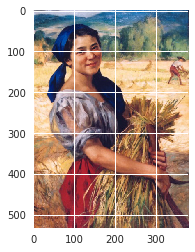

HAPPY? LIKELY


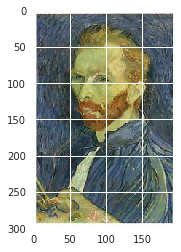

HAPPY? VERY_UNLIKELY


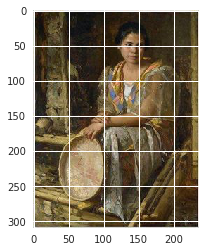

HAPPY? VERY_UNLIKELY


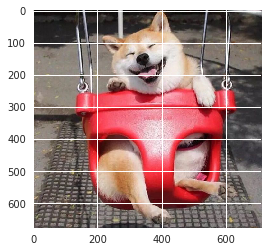

Unable to detect


In [76]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
import numpy as np

vservice = build('vision', 'v1', developerKey=APIKEY)

def get_face_sentiment(image):
  request = vservice.images().annotate(body={
          'requests': [{
                  'image': {
                      'source': {
                        'imageUri': image
                      }
                  },
                  'features': [{
                      'type': 'FACE_DETECTION',
                      'maxResults': 3,
                  }]
              }],
          })  
  imresponse = requests.get(image)
  imshow(np.asarray(Image.open(BytesIO(imresponse.content))))
  plt.show()
  r = request.execute(num_retries=3)
  try:
    print('HAPPY?', r['responses'][0]['faceAnnotations'][0]['joyLikelihood'])
  except:
    print('Unable to detect')

images = ['https://www.silent-gardens.com/new_assets/images/Culture/Palay-Maiden.jpg', 'https://i.ebayimg.com/images/g/VBAAAOSw2gxYq-Kh/s-l300.jpg', 
          'https://i.pinimg.com/236x/87/ce/31/87ce31ccde03beb25214d01aa801342e--filipino-art-portrait-paintings.jpg?b=t',
         'https://d3pz1jifuab5zg.cloudfront.net/2016/06/23105154/shiba-swing.jpg']
for i in images:
  get_face_sentiment(i)


Copyright 2018 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.